Inspired by this post by Jeremy Theler https://www.linkedin.com/posts/jeremytheler_how-to-solve-a-maze-without-ai-use-laplaces-activity-6831291311832760320-x9d5

In [1]:
import openpnm as op
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from PIL import Image
import requests
from io import BytesIO
import time

In [9]:
im_size = 'medium'

if im_size == 'small':
    url = 'https://imgur.com/ZLbV4eh.png'
elif im_size == 'medium':
    url = 'https://imgur.com/A3Jx8SJ.png'
else:
    url = 'https://imgur.com/FLJ21e5.png'

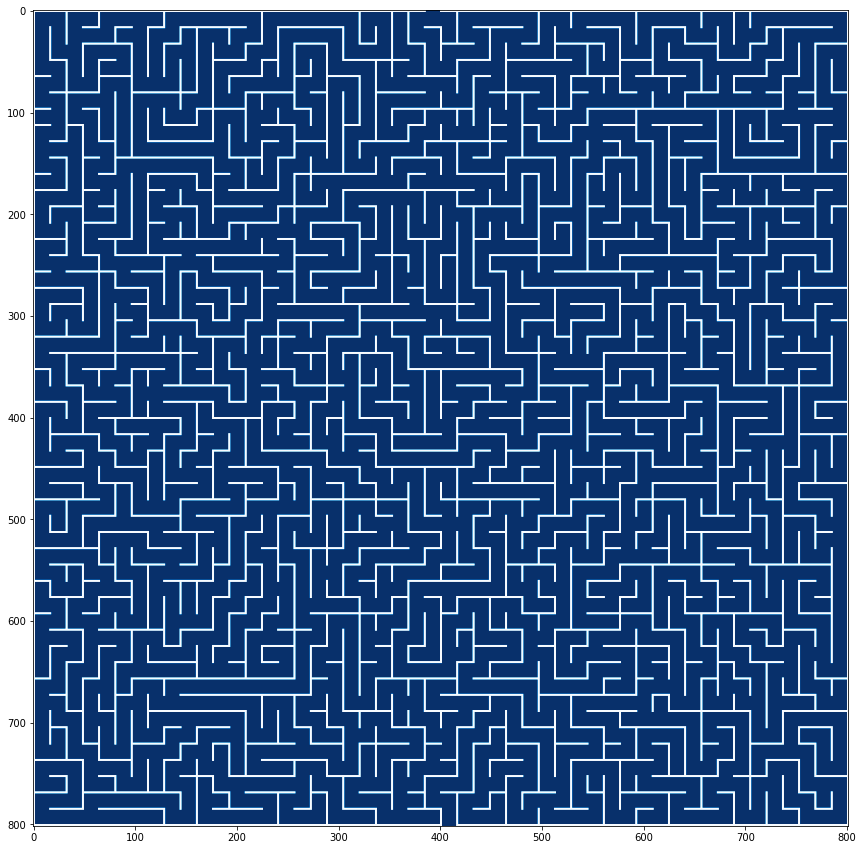

In [10]:
response = requests.get(url)
img = Image.open(BytesIO(response.content))
im = np.array(img.getdata()).reshape(img.size[0], img.size[1], 4)[:, :, 0]
im = im == 255

Nx, Ny, = im.shape

plt.figure(figsize=(15, 15))
plt.imshow(im, cmap='Blues')

In [11]:
# Structuring element for thickening walls
strel = np.array([[1, 1, 1],
                  [1, 1, 1],
                  [1, 1, 1]])

# Save some computation by thickening the walls
def thicken_wall(im):
    return ~ndimage.morphology.binary_dilation(~im, structure=strel)

for _ in range(5):
    im = thicken_wall(im)

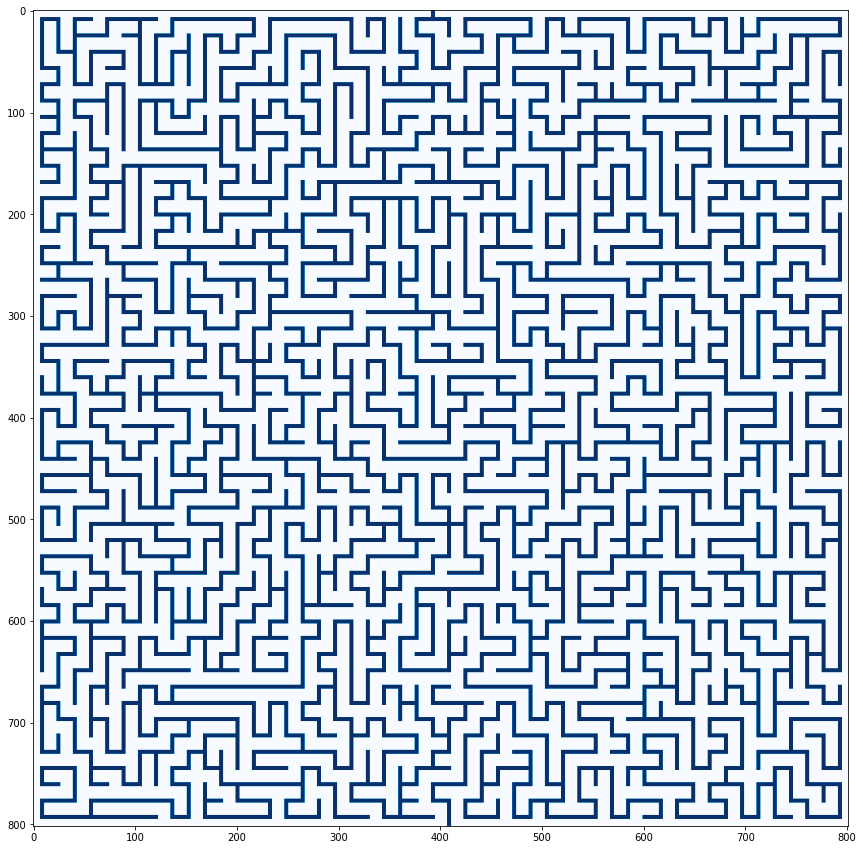

In [12]:
plt.figure(figsize=(15, 15))
plt.imshow(im, cmap='Blues')

In [13]:
# Get top and bottom boundaries
BP_top = np.zeros_like(im)
BP_bot = np.zeros_like(im)
BP_top[0, :] = True
BP_bot[-1, :] = True
BP_top *= im
BP_bot *= im

In [14]:
# Make a cubis network with same dimensions as image and assign the props
net = op.network.Cubic(shape=[Nx, Ny, 1])
net['pore.index'] = np.arange(0, net.Np)
net['pore.BP_top'] = BP_top.flatten()
net['pore.BP_bot'] = BP_bot.flatten()

# Trim wall pores
op.topotools.trim(network=net, pores=~im.flatten())

# Set up a dummy phase and apply uniform arbitrary conductance
phase = op.phases.GenericPhase(network=net)
phase['throat.electrical_conductance'] = 1.0

# Run algorithm
alg = op.algorithms.OhmicConduction(network=net, phase=phase)
alg.set_value_BC(pores=net.pores('BP_top'), values=0.0)
alg.set_value_BC(pores=net.pores('BP_bot'), values=1.0)
st = time.time()
alg.run()
et = time.time()
print('Solve time:', np.around(et - st, 3), 's')

Solve time: 0.45 s


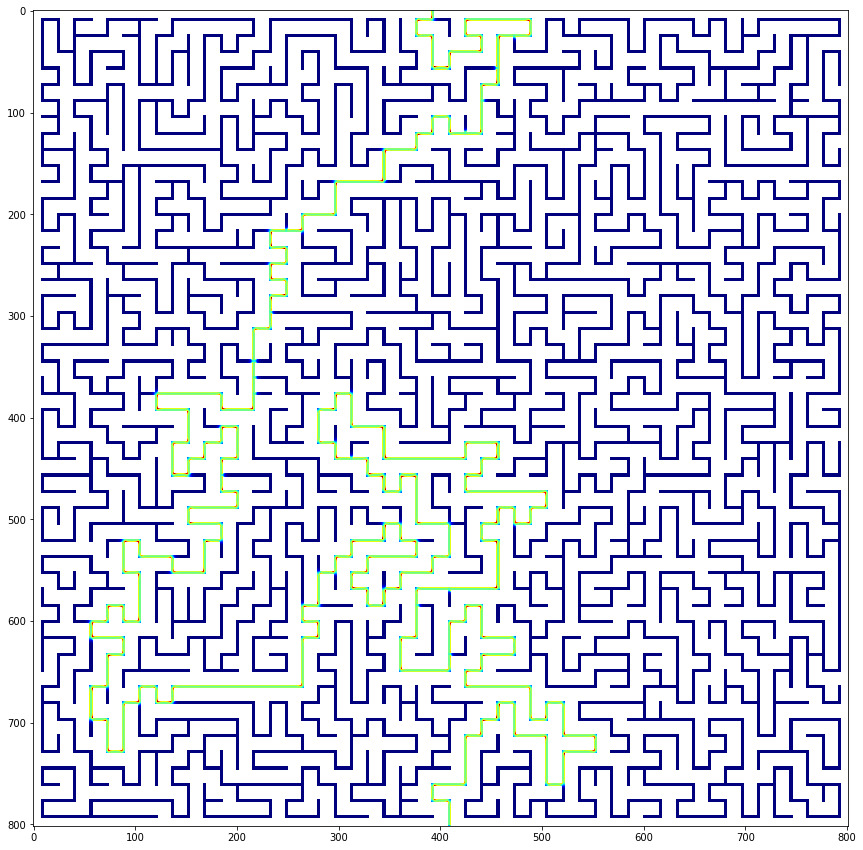

In [15]:
# Calculate flux in throats and show in pores
phase['throat.rate'] = alg.rate(throats=net.Ts, mode='single')
phase.add_model('pore.rate', op.models.misc.from_neighbor_throats,
                prop='throat.rate',
                mode='mean')
rate_im = np.ones([Nx, Ny]).flatten() * np.nan
rate_im[net['pore.index']] = phase['pore.rate']
rate_im = rate_im.reshape([Nx, Ny])
plt.figure(figsize=(15, 15))
plt.imshow(rate_im, cmap='jet')